In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionResNetV2,InceptionV3, VGG16,VGG19,ResNet50V2
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
import sys
sys.argv[1:]
sys.argv[1:] = '-d dataset -p plot -m model'.split()
#args = ap.parse_args()
#args

In [3]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="covid19.model",help="path to output loss/accuracy plot")

args = vars(ap.parse_args())
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 12
IMG_SIZE=224

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
	image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [5]:
print(len(labels))
print(len(data))

672
672


In [6]:
# perform one-hot encoding on the label
for idx, x in np.ndenumerate(labels):
   if x=='covid':
    labels[idx]=int(0)
   if x=='pneumonia':
    labels[idx]=int(1)
   if x=='normal':
    labels[idx]=int(2)


In [7]:
labels= labels.astype(np.integer)

In [8]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

import random
random.shuffle(data)

In [9]:
print(len(data))
data.ndim

672


4

In [10]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

537
135
537
135


In [11]:
testY

array([0, 1, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0, 1,
       0, 1, 0, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0,
       2, 0, 2, 1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 2,
       0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 1, 0, 1, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1,
       0, 0, 0])

In [12]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [13]:
## load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel= InceptionResNetV2(weights='imagenet', include_top=False,
	input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE,3)), )
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_2 = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False



In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=0.001, decay=INIT_LR / EPOCHS)
model_2.compile(loss="SparseCategoricalCrossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
from tensorflow.keras.callbacks import ModelCheckpoint
import math
checkpoint = ModelCheckpoint("3inceptcovvsnorvsother.hdf5", monitor='loss', verbose=1,
                             save_best_only=True, mode='auto', period=1)
H = model_2.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=math.floor(len(trainX)/BS),
	validation_data=(testX, testY),
	validation_steps=math.floor(len(testX)/BS),
	epochs=EPOCHS,callbacks=[checkpoint])

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
44/44 [==============================] - ETA: 0s - loss: 1.1278 - accuracy: 0.4659
Epoch 00001: loss improved from inf to 1.12782, saving model to 3inceptcovvsnorvsother.hdf5
44/44 [==============================] - 45s 1s/step - loss: 1.1278 - accuracy: 0.4659 - val_loss: 1.0191 - val_accuracy: 0.6000
Epoch 2/25
44/44 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5295
Epoch 00002: loss improved from 1.12782 to 1.01019, saving model to 3inceptcovvsnorvsother.hdf5
44/44 [==============================] - 44s 1s/step - loss: 1.0102 - accuracy: 0.5295 - val_loss: 0.6401 - val_accuracy: 0.6667
Epoch 3/25
44/44 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.5905
Epoch 00003: loss improved from 1.01019 to 0.78320, saving model to 3inceptcovvsnorvsother.hdf5
44/44 [==============================] - 49s 1s/st

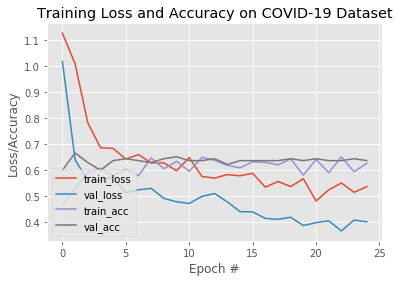

In [15]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

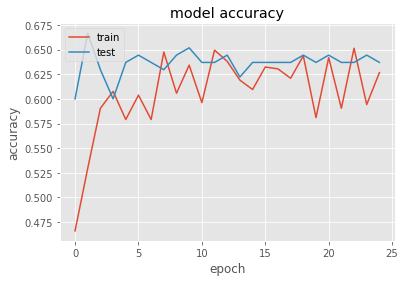

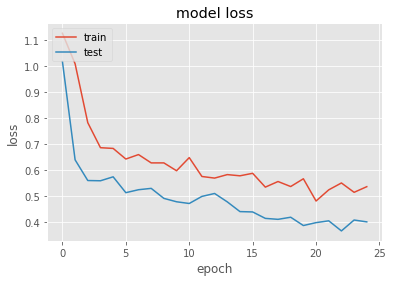

In [16]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model_2.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY, predIdxs, target_names=['covid','pneumonia','normal']))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.98      0.98      0.98        43
   pneumonia       0.48      0.98      0.64        45
      normal       0.00      0.00      0.00        47

    accuracy                           0.64       135
   macro avg       0.49      0.65      0.54       135
weighted avg       0.47      0.64      0.53       135



In [18]:
cm = confusion_matrix(testY, predIdxs)
total = sum(sum(cm)) 
acc = (cm[0, 0] + cm[1, 1]+cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]+cm[0,2])
specificity = cm[1, 1]+cm[2,2] / (cm[1, 0] + cm[1, 1]+cm[1,2]+cm[2,0]+cm[2,1]+cm[2,2])

print(cm)
print("acc: {:.4f}".format
      (acc))
#print("sensitivity: {:.4f}".format(sensitivity))
#print("specificity: {:.4f}".format(specificity))

[[42  1  0]
 [ 1 44  0]
 [ 0 47  0]]
acc: 0.6370


Confusion matrix, without normalization
[[42  1  0]
 [ 1 44  0]
 [ 0 47  0]]


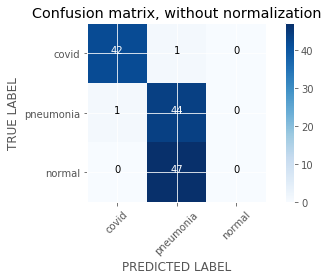

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('TRUE LABEL')
    plt.xlabel('PREDICTED LABEL')
    plt.tight_layout()
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['covid','pneumonia','normal'],
                      title='Confusion matrix, without normalization')

In [20]:
model_2.save("inceptmodel3cl")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inceptmodel3cl/assets
